In [1]:
import os
import numpy as np
import threading as thr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, InputLayer, Activation, Dropout
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD

In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [3]:
mammo_o, mammo_f, label = [], [], []
data_folder = "../dataset/"
os.chdir(data_folder)
l = os.listdir()

In [4]:
def create_dataset(lista, o_img, f_img, labels):
    #Function calling the Matlab file in order to filter the images.
    for element in lista:
        if "_1_resized.pgm" in element:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(data_folder, element)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            labels.append(1)
        elif "_2_resized.pgm" in element:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(data_folder, element)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            labels.append(0)

In [5]:
os.chdir("./")
threads = []
chunk = 6

for i in range(49):
    t = thr.Thread(target = create_dataset, args = (l[i*chunk : (i+1)*chunk], mammo_o, mammo_f, label))
    threads.append(t)
    t.start()
    
for j in threads:
    j.join()

In [6]:
mammo_o = np.asarray(mammo_o, dtype = 'float32')/255.
mammo_f = np.asarray(mammo_f, dtype = 'float32')/255.
label = np.asarray(label)
mammo_o_4d = np.reshape(mammo_o, (147, 125, 125, 1))
print(mammo_o_4d.shape)
mammo_f_4d = np.reshape(mammo_f, (147, 64, 64, 1))
print(mammo_f_4d.shape)

(147, 125, 125, 1)
(147, 64, 64, 1)


In [7]:
def cnn_o(shape=(125, 125, 1)):
    model = Sequential([
        
        Conv2D(4, (3,3), padding = 'same', input_shape = shape),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        Dropout(0.1),
        
        
        Conv2D(8, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        #Dropout(0.2),
        
        
        Conv2D(10, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        Dropout(0.2),
        
        Flatten(),
        
        Dense(10, activation = 'relu'),
        #Dropout(0.1),
        Dense(1, activation = 'sigmoid')        
        
    ])
    
    return model

In [8]:
model_o = cnn_o()
model_o.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 4)       40        
                                                                 
 batch_normalization (BatchN  (None, 125, 125, 4)      16        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 125, 125, 4)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 4)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 4)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 8)         2

In [9]:
learning_rate = 0.001
model_o.compile(optimizer = SGD(learning_rate, momentum = 0.9), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [10]:
reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

In [11]:
X_train_o, X_val_o, Y_train_o, Y_val_o = train_test_split(mammo_o_4d, label, test_size = 0.2, random_state = 44)
batch_size = 21
train_o = model_o.fit(X_train_o, Y_train_o,
                     batch_size = batch_size,
                     epochs = 260, 
                     verbose = 1,
                     validation_data = (X_val_o, Y_val_o),
                     callbacks = [reduce_on_plateau])    

Epoch 1/260
6/6 [==============================] - 3s 296ms/step - loss: 0.8294 - accuracy: 0.5470 - val_loss: 0.6887 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 2/260
6/6 [==============================] - 1s 234ms/step - loss: 0.6975 - accuracy: 0.6496 - val_loss: 0.6848 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 3/260
6/6 [==============================] - 1s 238ms/step - loss: 0.6409 - accuracy: 0.7009 - val_loss: 0.6802 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 4/260
6/6 [==============================] - 1s 229ms/step - loss: 0.6135 - accuracy: 0.7179 - val_loss: 0.6811 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 5/260
6/6 [==============================] - 1s 219ms/step - loss: 0.6060 - accuracy: 0.7009 - val_loss: 0.6882 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 6/260
6/6 [==============================] - 1s 218ms/step - loss: 0.5756 - accuracy: 0.6923 - val_loss: 0.6993 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 7/260
6/6 [==============================] - 1s 220ms/step - loss: 0.5

Epoch 53/260
6/6 [==============================] - 1s 218ms/step - loss: 0.5226 - accuracy: 0.7607 - val_loss: 0.9556 - val_accuracy: 0.5667 - lr: 1.0000e-07
Epoch 54/260
6/6 [==============================] - 1s 219ms/step - loss: 0.4767 - accuracy: 0.7778 - val_loss: 0.9527 - val_accuracy: 0.5667 - lr: 1.0000e-08
Epoch 55/260
6/6 [==============================] - 1s 216ms/step - loss: 0.4994 - accuracy: 0.7607 - val_loss: 0.9502 - val_accuracy: 0.5667 - lr: 1.0000e-08
Epoch 56/260
6/6 [==============================] - 1s 217ms/step - loss: 0.4663 - accuracy: 0.7607 - val_loss: 0.9471 - val_accuracy: 0.5667 - lr: 1.0000e-08
Epoch 57/260
6/6 [==============================] - 1s 217ms/step - loss: 0.4973 - accuracy: 0.7863 - val_loss: 0.9447 - val_accuracy: 0.5667 - lr: 1.0000e-08
Epoch 58/260
6/6 [==============================] - 1s 215ms/step - loss: 0.4595 - accuracy: 0.7949 - val_loss: 0.9422 - val_accuracy: 0.5667 - lr: 1.0000e-08
Epoch 59/260
6/6 [============================

6/6 [==============================] - 1s 214ms/step - loss: 0.4966 - accuracy: 0.7778 - val_loss: 0.6610 - val_accuracy: 0.6333 - lr: 1.0000e-12
Epoch 105/260
6/6 [==============================] - 1s 215ms/step - loss: 0.4660 - accuracy: 0.7863 - val_loss: 0.6564 - val_accuracy: 0.6333 - lr: 1.0000e-12
Epoch 106/260
6/6 [==============================] - 1s 214ms/step - loss: 0.4704 - accuracy: 0.7436 - val_loss: 0.6522 - val_accuracy: 0.6333 - lr: 1.0000e-12
Epoch 107/260
6/6 [==============================] - 1s 218ms/step - loss: 0.4817 - accuracy: 0.7863 - val_loss: 0.6485 - val_accuracy: 0.6333 - lr: 1.0000e-12
Epoch 108/260
6/6 [==============================] - 1s 219ms/step - loss: 0.4766 - accuracy: 0.7692 - val_loss: 0.6447 - val_accuracy: 0.6333 - lr: 1.0000e-12
Epoch 109/260
6/6 [==============================] - 1s 217ms/step - loss: 0.4955 - accuracy: 0.7521 - val_loss: 0.6415 - val_accuracy: 0.6333 - lr: 1.0000e-12
Epoch 110/260
6/6 [==============================] - 1

6/6 [==============================] - 1s 221ms/step - loss: 0.4780 - accuracy: 0.7863 - val_loss: 0.5799 - val_accuracy: 0.6667 - lr: 1.0000e-12
Epoch 156/260
6/6 [==============================] - 1s 218ms/step - loss: 0.4842 - accuracy: 0.7778 - val_loss: 0.5799 - val_accuracy: 0.6667 - lr: 1.0000e-12
Epoch 157/260
6/6 [==============================] - 1s 217ms/step - loss: 0.4790 - accuracy: 0.7607 - val_loss: 0.5798 - val_accuracy: 0.6667 - lr: 1.0000e-12
Epoch 158/260
6/6 [==============================] - 1s 217ms/step - loss: 0.5010 - accuracy: 0.7436 - val_loss: 0.5793 - val_accuracy: 0.6667 - lr: 1.0000e-12
Epoch 159/260
6/6 [==============================] - 1s 218ms/step - loss: 0.4877 - accuracy: 0.7949 - val_loss: 0.5789 - val_accuracy: 0.6667 - lr: 1.0000e-12
Epoch 160/260
6/6 [==============================] - 1s 223ms/step - loss: 0.4689 - accuracy: 0.7692 - val_loss: 0.5786 - val_accuracy: 0.6667 - lr: 1.0000e-12
Epoch 161/260
6/6 [==============================] - 2

6/6 [==============================] - 1s 235ms/step - loss: 0.4854 - accuracy: 0.7692 - val_loss: 0.5759 - val_accuracy: 0.6667 - lr: 1.0000e-13
Epoch 207/260
6/6 [==============================] - 1s 248ms/step - loss: 0.4852 - accuracy: 0.7778 - val_loss: 0.5759 - val_accuracy: 0.6667 - lr: 1.0000e-13
Epoch 208/260
6/6 [==============================] - 1s 247ms/step - loss: 0.4685 - accuracy: 0.7521 - val_loss: 0.5760 - val_accuracy: 0.6667 - lr: 1.0000e-13
Epoch 209/260
6/6 [==============================] - 1s 226ms/step - loss: 0.4613 - accuracy: 0.8034 - val_loss: 0.5762 - val_accuracy: 0.6667 - lr: 1.0000e-13
Epoch 210/260
6/6 [==============================] - 1s 222ms/step - loss: 0.4631 - accuracy: 0.7607 - val_loss: 0.5762 - val_accuracy: 0.6667 - lr: 1.0000e-13
Epoch 211/260
6/6 [==============================] - 1s 226ms/step - loss: 0.4762 - accuracy: 0.7607 - val_loss: 0.5764 - val_accuracy: 0.6667 - lr: 1.0000e-13
Epoch 212/260
6/6 [==============================] - 1

6/6 [==============================] - 1s 221ms/step - loss: 0.5004 - accuracy: 0.7778 - val_loss: 0.5752 - val_accuracy: 0.6667 - lr: 1.0000e-17
Epoch 258/260
6/6 [==============================] - 1s 219ms/step - loss: 0.5039 - accuracy: 0.7350 - val_loss: 0.5753 - val_accuracy: 0.6667 - lr: 1.0000e-17
Epoch 259/260
6/6 [==============================] - 1s 219ms/step - loss: 0.5078 - accuracy: 0.7521 - val_loss: 0.5754 - val_accuracy: 0.6667 - lr: 1.0000e-17
Epoch 260/260
6/6 [==============================] - 1s 221ms/step - loss: 0.4668 - accuracy: 0.7692 - val_loss: 0.5757 - val_accuracy: 0.6667 - lr: 1.0000e-17


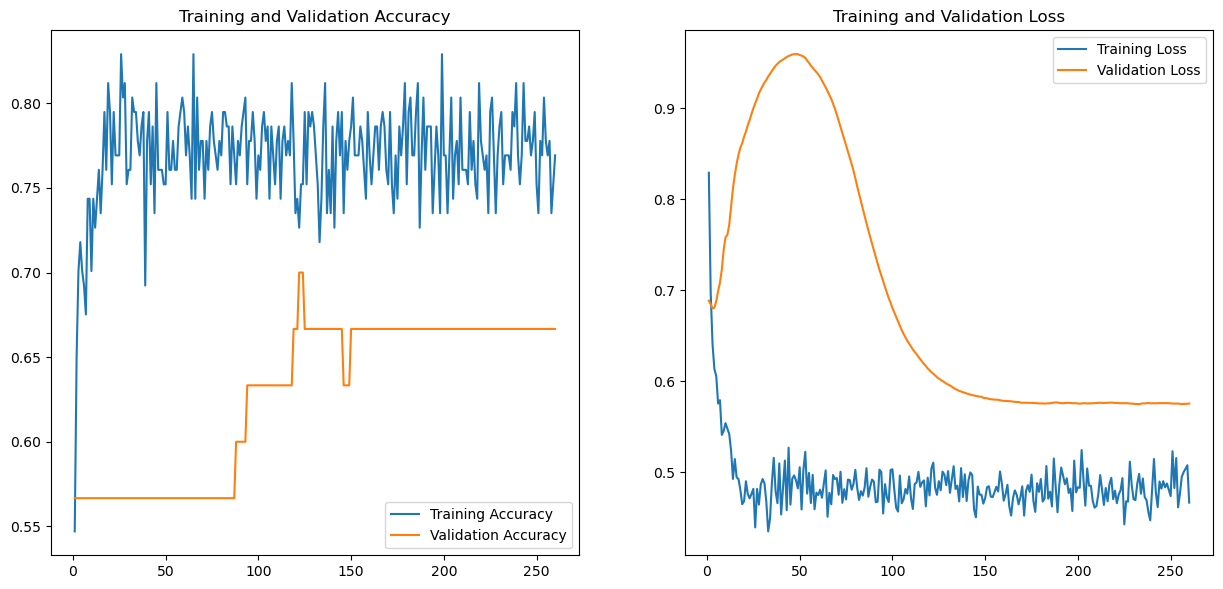

In [12]:
acc = train_o.history['accuracy']
val_acc = train_o.history['val_accuracy']
loss = train_o.history['loss']
val_loss = train_o.history['val_loss']

epochs_range = range(1, len(acc)+1)

#Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Train and validation loss 
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
def cnn_o_aug(shape=(125, 125, 1)):
    model = Sequential([
        
        Conv2D(6, (3,3), padding = 'same', input_shape = shape),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        Dropout(0.1),
        
        
        Conv2D(8, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        #Dropout(0.2),
        
        
        Conv2D(10, (3,3), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        Dropout(0.2),
        
        Flatten(),
        
        Dense(10, activation = 'relu'),
        #Dropout(0.1),
        Dense(1, activation = 'sigmoid')        
        
    ])
    
    return model

In [14]:
model_o_aug = cnn_o_aug()
model_o_aug.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 125, 125, 6)       60        
                                                                 
 batch_normalization_3 (Batc  (None, 125, 125, 6)      24        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 125, 125, 6)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 60, 60, 6)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 60, 60, 6)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 8)        

In [15]:
learning_rate = 0.001
model_o_aug.compile(optimizer = SGD(learning_rate, momentum = 0.9), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [16]:
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
                rotation_range = 90,
                horizontal_flip = True,
                vertical_flip = True,
                validation_split = 0.20)

aug_train_o = aug.flow(mammo_o_4d, label, batch_size = 30, subset = 'training')
aug_val_o = aug.flow(mammo_o_4d, label, batch_size = 30, subset = 'validation')

In [17]:
batch_size = 42
train_o_aug = model_o_aug.fit(aug_train_o, 
                     batch_size = batch_size,
                     epochs = 260, 
                     verbose = 1,
                     validation_data = aug_val_o,
                     callbacks = [reduce_on_plateau])    

Epoch 1/260
4/4 [==============================] - 3s 509ms/step - loss: 1.0477 - accuracy: 0.4661 - val_loss: 0.6915 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 2/260
4/4 [==============================] - 2s 419ms/step - loss: 0.8616 - accuracy: 0.6017 - val_loss: 0.7000 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 3/260
4/4 [==============================] - 2s 436ms/step - loss: 0.5919 - accuracy: 0.7373 - val_loss: 0.7062 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 4/260
4/4 [==============================] - 2s 468ms/step - loss: 0.6373 - accuracy: 0.6356 - val_loss: 0.7058 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 5/260
4/4 [==============================] - 2s 443ms/step - loss: 0.5908 - accuracy: 0.6949 - val_loss: 0.7090 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 6/260
4/4 [==============================] - 2s 480ms/step - loss: 0.5666 - accuracy: 0.7034 - val_loss: 0.7130 - val_accuracy: 0.5172 - lr: 0.0010
Epoch 7/260
4/4 [==============================] - 2s 469ms/step - loss: 0.6

Epoch 53/260
4/4 [==============================] - 2s 422ms/step - loss: 0.5621 - accuracy: 0.7797 - val_loss: 0.9004 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 54/260
4/4 [==============================] - 2s 433ms/step - loss: 0.5798 - accuracy: 0.7288 - val_loss: 0.8961 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 55/260
4/4 [==============================] - 2s 428ms/step - loss: 0.5574 - accuracy: 0.7458 - val_loss: 0.9074 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 56/260
4/4 [==============================] - 2s 416ms/step - loss: 0.5641 - accuracy: 0.7542 - val_loss: 0.9293 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 57/260
4/4 [==============================] - 2s 419ms/step - loss: 0.5687 - accuracy: 0.6949 - val_loss: 0.9183 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 58/260
4/4 [==============================] - 2s 426ms/step - loss: 0.5718 - accuracy: 0.7203 - val_loss: 0.9162 - val_accuracy: 0.5172 - lr: 1.0000e-08
Epoch 59/260
4/4 [============================

4/4 [==============================] - 2s 424ms/step - loss: 0.5504 - accuracy: 0.7542 - val_loss: 0.8863 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 105/260
4/4 [==============================] - 2s 415ms/step - loss: 0.5480 - accuracy: 0.7542 - val_loss: 0.9341 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 106/260
4/4 [==============================] - 2s 423ms/step - loss: 0.5533 - accuracy: 0.7712 - val_loss: 0.8932 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 107/260
4/4 [==============================] - 2s 431ms/step - loss: 0.5715 - accuracy: 0.7034 - val_loss: 0.9181 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 108/260
4/4 [==============================] - 2s 417ms/step - loss: 0.5341 - accuracy: 0.7627 - val_loss: 0.9111 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 109/260
4/4 [==============================] - 2s 416ms/step - loss: 0.6022 - accuracy: 0.7458 - val_loss: 0.9088 - val_accuracy: 0.5172 - lr: 1.0000e-13
Epoch 110/260
4/4 [==============================] - 2

4/4 [==============================] - 2s 420ms/step - loss: 0.5731 - accuracy: 0.6695 - val_loss: 0.7956 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 156/260
4/4 [==============================] - 2s 451ms/step - loss: 0.5784 - accuracy: 0.7034 - val_loss: 0.8029 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 157/260
4/4 [==============================] - 2s 509ms/step - loss: 0.5161 - accuracy: 0.7712 - val_loss: 0.8295 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 158/260
4/4 [==============================] - 2s 471ms/step - loss: 0.5512 - accuracy: 0.7627 - val_loss: 0.7886 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 159/260
4/4 [==============================] - 2s 430ms/step - loss: 0.5686 - accuracy: 0.7542 - val_loss: 0.7865 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 160/260
4/4 [==============================] - 2s 426ms/step - loss: 0.5631 - accuracy: 0.6949 - val_loss: 0.7875 - val_accuracy: 0.5172 - lr: 1.0000e-18
Epoch 161/260
4/4 [==============================] - 2

4/4 [==============================] - 2s 447ms/step - loss: 0.5288 - accuracy: 0.7373 - val_loss: 0.7534 - val_accuracy: 0.5517 - lr: 1.0000e-23
Epoch 207/260
4/4 [==============================] - 2s 424ms/step - loss: 0.5549 - accuracy: 0.7203 - val_loss: 0.8094 - val_accuracy: 0.5172 - lr: 1.0000e-23
Epoch 208/260
4/4 [==============================] - 2s 428ms/step - loss: 0.5965 - accuracy: 0.6949 - val_loss: 0.8030 - val_accuracy: 0.5172 - lr: 1.0000e-23
Epoch 209/260
4/4 [==============================] - 2s 437ms/step - loss: 0.5688 - accuracy: 0.7373 - val_loss: 0.7454 - val_accuracy: 0.5172 - lr: 1.0000e-23
Epoch 210/260
4/4 [==============================] - 2s 435ms/step - loss: 0.5521 - accuracy: 0.7458 - val_loss: 0.7803 - val_accuracy: 0.5172 - lr: 1.0000e-23
Epoch 211/260
4/4 [==============================] - 2s 422ms/step - loss: 0.5757 - accuracy: 0.7373 - val_loss: 0.8162 - val_accuracy: 0.5172 - lr: 1.0000e-23
Epoch 212/260
4/4 [==============================] - 2

4/4 [==============================] - 2s 432ms/step - loss: 0.5744 - accuracy: 0.7542 - val_loss: 0.8201 - val_accuracy: 0.5172 - lr: 1.0000e-28
Epoch 258/260
4/4 [==============================] - 2s 424ms/step - loss: 0.5311 - accuracy: 0.7542 - val_loss: 0.8206 - val_accuracy: 0.5172 - lr: 1.0000e-28
Epoch 259/260
4/4 [==============================] - 2s 428ms/step - loss: 0.5675 - accuracy: 0.7288 - val_loss: 0.7812 - val_accuracy: 0.5172 - lr: 1.0000e-28
Epoch 260/260
4/4 [==============================] - 2s 452ms/step - loss: 0.5353 - accuracy: 0.7542 - val_loss: 0.7581 - val_accuracy: 0.5172 - lr: 1.0000e-28


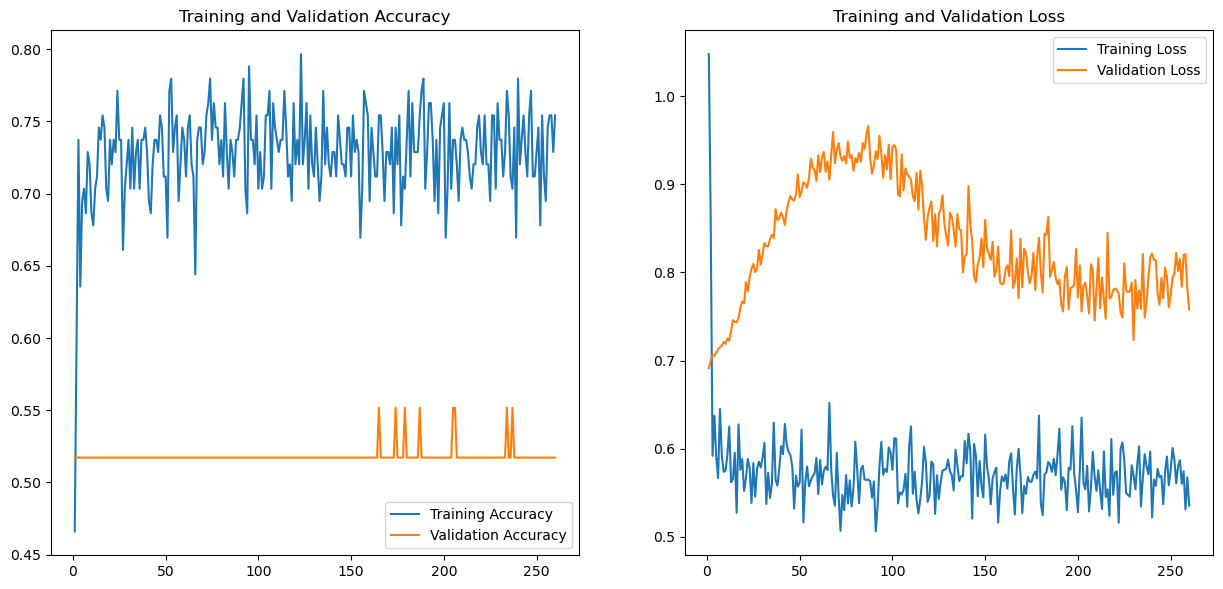

In [18]:
acc = train_o_aug.history['accuracy']
val_acc = train_o_aug.history['val_accuracy']
loss = train_o_aug.history['loss']
val_loss = train_o_aug.history['val_loss']

epochs_range = range(1, len(acc)+1)

#Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Train and validation loss 
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
acc_o = []
acc_o_aug = []
for i in range(10):
    
    _, val_acc = model_o.evaluate(X_val_o, Y_val_o, verbose=0)
    print('Validation accuracy: %.3f' % (val_acc))
    acc_o.append(val_acc)

    _, val_acc = model_o_aug.evaluate(aug_val_o, verbose=0)
    print('Validation accuracy: %.3f' % (val_acc))
    acc_o_aug.append(val_acc)

Validation accuracy: 0.667
Validation accuracy: 0.517
Validation accuracy: 0.667
Validation accuracy: 0.517
Validation accuracy: 0.667
Validation accuracy: 0.517
Validation accuracy: 0.667
Validation accuracy: 0.517
Validation accuracy: 0.667
Validation accuracy: 0.552
Validation accuracy: 0.667
Validation accuracy: 0.517
Validation accuracy: 0.667
Validation accuracy: 0.517
Validation accuracy: 0.667
Validation accuracy: 0.517
Validation accuracy: 0.667
Validation accuracy: 0.517
Validation accuracy: 0.667
Validation accuracy: 0.517


In [20]:
media_o = np.mean(acc_o)
std_o = np.std(acc_o)
print(media_o)
print(std_o)

0.6666666865348816
0.0


In [21]:
media_o_aug = np.mean(acc_o_aug)
std_o_aug = np.std(acc_o_aug)
print(media_o_aug)
print(std_o_aug)

0.5206896364688873
0.010344833135604858


In [22]:
mammo_o_t, mammo_f_t, label_t = [], [], []
data_folder_t = "../test_dataset/"
os.chdir(data_folder_t)
l_t = os.listdir()

In [23]:
def create_dataset_t(lista, o_img, f_img, labels):
    #Function calling the Matlab file in order to filter the images.
    for element in lista:
        if "_1_resized.pgm" in element:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(data_folder_t, element)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            labels.append(1)
        elif "_2_resized.pgm" in element:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(data_folder_t, element)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            labels.append(0)

In [24]:
os.chdir("./")
threads = []
chunk = 6

for i in range(10):
    t = thr.Thread(target = create_dataset_t, args = (l_t[i*chunk : (i+1)*chunk], mammo_o_t, mammo_f_t, label_t))
    threads.append(t)
    t.start()
    
for j in threads:
    j.join()

In [25]:
eng.quit()

In [26]:
mammo_o_t = np.asarray(mammo_o_t, dtype = 'float32')/255.
mammo_f_t = np.asarray(mammo_f_t, dtype = 'float32')/255.
label_t = np.asarray(label_t)
mammo_o_4d_t = np.reshape(mammo_o_t, (30, 125, 125, 1))
print(mammo_o_4d_t.shape)
mammo_f_4d_t = np.reshape(mammo_f_t, (30, 64, 64, 1))
print(mammo_f_4d_t.shape)

(30, 125, 125, 1)
(30, 64, 64, 1)


In [27]:
if media_o > media_o_aug:
    test_loss, test_acc = model_o.evaluate(mammo_o_4d_t, label_t)
    preds_test = model_o.predict(mammo_o_4d_t, verbose=1)
    fpr, tpr, _ = roc_curve(label_t, preds_test)
    roc_auc = auc(fpr, tpr)

    print('\n Test accuracy = %.3f'% (test_acc))
    print('\n AUC = %.3f'% (roc_auc))
else:
    test_loss, test_acc = model_o_aug.evaluate(mammo_o_4d_t, label_t)
    preds_test = model_o_aug.predict(mammo_o_4d_t, verbose=1)
    fpr, tpr, _ = roc_curve(label_t, preds_test)
    roc_auc = auc(fpr, tpr)
    
    print('\n Test accuracy = %.3f'% (test_acc))
    print('\n AUC = %.3f'% (roc_auc))

1/1 [==============================] - 0s 388ms/step

 Test accuracy = 0.367

 AUC = 0.486
